In [1]:
# https://www.kaggle.com/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import math
from collections import Counter
# import numpy as np
import seaborn as sns
# import pandas as pd
import scipy.stats as ss
# import matplotlib.pyplot as plt
import sklearn.preprocessing as sp
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from subprocess import check_output


#Dataframe Visual Settings
pd.set_option('display.max_rows',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',400)

def clean_bank_statement_file(filename):
    """
    Extract, modify & clean bank statement raw file for neater format
    """
    #Cleaning data
    # csv_file = '\Bank Statements\'' + filename
    df = pd.read_csv(filename,
                     usecols=['Transaction Number','Date','Memo','Amount Debit','Amount Credit'],
                     skiprows=3)
    
    df.fillna({'Amount Debit':0, 'Amount Credit':0},inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
    df.sort_values(by=['Date'],ascending=False,ignore_index=True,inplace=True)
    df['Memo'].fillna('Default',inplace=True)
    df['Transaction Number'] = df['Transaction Number'].apply(lambda x: x.split('**')[1])
    df['Purchase Date'] = df[df['Memo'].str.contains('1574 ',na=False)]['Memo']\
        .apply(lambda x: x.split('1574 ')[1])
    df['Purchase Date'] = pd.to_datetime(df['Purchase Date'],format = '%m/%d %H:%M')
    df['Purchase Date'] = df['Purchase Date']+pd.DateOffset(years=120)
    df.loc[df['Purchase Date'].isna(),'Purchase Date'] = df['Date'].copy()
    df['Memo'] = df['Memo'].apply(lambda x: x.split('*****')[0])
    df['Content'] = df['Transaction Number'] + ' ' + df['Memo']
    df['Amount'] = df['Amount Debit'].astype(float) + df['Amount Credit'].astype(float)
    df['Category'] = 'Default'
    df.drop(df[df['Content'].str.contains("INTERNET TRANSFER",na=False)].index,inplace=True)
    df.reset_index(drop=True,inplace=True)
    df.drop(['Transaction Number','Memo','Amount Debit','Amount Credit'],
            axis=1,inplace=True)
    df.sort_values(by=['Purchase Date'],ascending=False, inplace=True)
    return df

def categorize(df):
    """
    For common transactions, categorize these early, and use to train a model
    """
    #Easier Categorization
    df.loc[df['Content'].str.contains("UBER EATS",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("HARRIS",na=False),'Category'] = 'Groceries'
    df.loc[df['Content'].str.contains("GIANT",na=False),'Category'] = 'Groceries'
    df.loc[df['Content'].str.contains("USAA",na=False),'Category'] = 'USAA Insurance'
    df.loc[df['Content'].str.contains("Accenture",na=False),'Category'] = 'Pay Check'
    df.loc[df['Content'].str.contains("XSPORT",na=False),'Category'] = 'Gym'
    df.loc[df['Content'].str.contains("DISTRICT MARTIAL ARTS",na=False),'Category'] = 'Gym'
    df.loc[df['Content'].str.contains("PARKING",na=False),'Category'] = 'Tolls/Uber/Metro/Parking'
    df.loc[df['Content'].str.contains("NAZRET",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("TAJ OF INDIA",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("DCPILLAR",na=False),'Category'] = 'Tithe'
    df.loc[df['Content'].str.contains("GOOGLE",na=False),'Category'] = 'Entertainment'
    df.loc[df['Content'].str.contains("VENMO/CASHOUT",na=False),'Category'] = 'Venmo Extra'
    df.loc[df['Content'].str.contains("CITGO",na=False),'Category'] = 'Gas'
    df.loc[df['Content'].str.contains("SHELL",na=False),'Category'] = 'Gas'
    df.loc[df['Content'].str.contains("PUPATELLA",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("GOOD COMPANY DONUT",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("STARBUCKS",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("UBER TRIP",na=False),'Category'] = 'Tolls/Uber/Metro/Parking'
    df.loc[df['Content'].str.contains("VERIZON",na=False),'Category'] = 'Utilities'
    df.loc[df['Content'].str.contains("WASHINGTON GAS",na=False),'Category'] = 'Utilities'
    df.loc[df['Content'].str.contains("ENERGY",na=False),'Category'] = 'Utilities'
    df.loc[df['Content'].str.contains("TOM COLEMAN",na=False),'Category'] = 'Phone'
    df.loc[df['Content'].str.contains("STDNT LOAN",na=False),'Category'] = 'Student Loans'
    df.loc[(df['Content'].str.contains("VENMO/PAYMENTWALTER COLEMAN Default",na=False)) &
           (df['Amount'] == -668.75),'Category'] = 'Rent'
    df.loc[df['Content'].str.contains("Margaret Coleman",na=False),'Category'] = 'Extra'
    df.loc[df['Content'].str.contains("Person-to-Person TransferPAYPAL",na=False),'Category'] = 'Extra'
    return df 

def create_grand_file(directory):
    """
    Extract based on string file names
    """
    grand_df = pd.DataFrame()
    temp_df = pd.DataFrame()

    #Get list of files
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            temp_df = clean_bank_statement_file(filename)
            temp_df = categorize(temp_df)
            grand_df = pd.concat([grand_df,temp_df],ignore_index=True)
    
    return grand_df

directory = r'C:\Users\waltj\OneDrive\Data Science Self Learning\BankStatementOrganizer'
grand_df = create_grand_file(directory)

In [4]:
grand_df

,Date,Purchase Date,Content,Amount,Category
0,2020-04-29,2020-04-29 12:47:00,POS PURCHASE with PINGIANT 0774 ARLINGTON VA 001,-5.11,Groceries
1,2020-04-29,2020-04-29 02:32:00,Person-to-Person TransferPOP*Margaret Coleman Visa Direct VAPOPMON,250.00,Extra
2,2020-04-29,2020-04-28 22:44:00,POS PURCHASE Non-PINPP*GOOGLE A MEDIUM CORP 402-935-7733 CAINC000,-4.99,Entertainment
3,2020-04-28,2020-04-28 13:17:00,POS PURCHASE with PINGIANT 0774 ARLINGTON VA 001,-5.11,Groceries
4,2020-04-27,2020-04-26 22:23:00,POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA INB600,-21.23,Dining Out
5,2020-04-27,2020-04-26 22:23:00,POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA INB500,-3.70,Dining Out
6,2020-04-24,2020-04-24 15:16:00,POS PURCHASE with PINGIANT 0774 ARLINGTON VA 001,-47.51,Groceries
7,2020-04-23,2020-04-23 03:43:00,POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN1610,-17.49,Dining Out
8,2020-04-23,2020-04-23 03:43:00,POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN8900,-2.09,Dining Out
9,2020-04-23,2020-04-22 19:30:00,POS PURCHASE Non-PINVTG*Emmaus Family Couns 703-7292822 VA000000,-125.00,Default


In [19]:
grand_df.head()

,Date,Purchase Date,Content,Amount,Category
0,2020-04-29,2020-04-29 12:47:00,POS PURCHASE with PINGIANT 0774 ARLINGTON VA 001,-5.11,Groceries
1,2020-04-29,2020-04-29 02:32:00,Person-to-Person TransferPOP*Margaret Coleman Visa Direct VAPOPMON,250.00,Extra
2,2020-04-29,2020-04-28 22:44:00,POS PURCHASE Non-PINPP*GOOGLE A MEDIUM CORP 402-935-7733 CAINC000,-4.99,Entertainment
3,2020-04-28,2020-04-28 13:17:00,POS PURCHASE with PINGIANT 0774 ARLINGTON VA 001,-5.11,Groceries
4,2020-04-27,2020-04-26 22:23:00,POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA INB600,-21.23,Dining Out


In [16]:
grand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 757 entries, 0 to 756
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           757 non-null    datetime64[ns]
 1   Purchase Date  757 non-null    datetime64[ns]
 2   Content        757 non-null    object        
 3   Amount         757 non-null    float64       
 4   Category       757 non-null    object        
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 29.7+ KB


In [20]:
print(len(grand_df))
print(min(grand_df['Amount']))
print(sum(grand_df['Amount']))

757
-5486.0
-7944.410000000004


In [21]:
grand_df.corr()

,Amount
Amount,1.0


In [ ]:
# Decision Tree, Random Forest with Word Vector
# Create type of transaction column
# Find any additional columns from bank statement to keep as granular as possible
# Group strings of diverse statements together (much of which is already done)
# Encode for random forest
# Use correlation heatmap to see strongest correlation

In [27]:
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

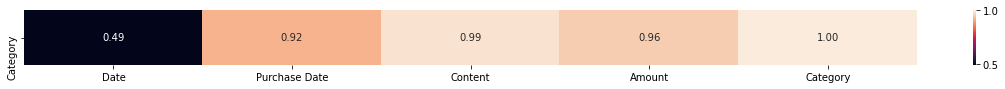

In [28]:
theilu = pd.DataFrame(index=['Category'],columns=grand_df.columns)
columns = grand_df.columns
for j in range(0,len(columns)):
    u = theil_u(grand_df['Category'].tolist(),grand_df[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu,annot=True,fmt='.2f')
plt.show()

In [29]:
grand_df.columns

Index(['Date', 'Purchase Date', 'Content', 'Amount', 'Category'], dtype='object')

In [30]:
print('hello world')

hello world


In [31]:
#encode categorical columns
grand_df['Category_encoded'] = grand_df['Category'].apply(lambda x: x.encode('base64','strict'))

LookupError: 'base64' is not a text encoding; use codecs.encode() to handle arbitrary codecs

In [32]:
grand_df['Category_encoded'] = map(lambda x: x.encode('base64','strict'), grand_df['Category'])

In [36]:
grand_df['Category_encoded'] = map(int, grand_df['Category'])

In [37]:
grand_df['Category_encoded']

0      <map object at 0x000001A76A50C250>
1      <map object at 0x000001A76A50C250>
2      <map object at 0x000001A76A50C250>
3      <map object at 0x000001A76A50C250>
4      <map object at 0x000001A76A50C250>
5      <map object at 0x000001A76A50C250>
6      <map object at 0x000001A76A50C250>
7      <map object at 0x000001A76A50C250>
8      <map object at 0x000001A76A50C250>
9      <map object at 0x000001A76A50C250>
10     <map object at 0x000001A76A50C250>
11     <map object at 0x000001A76A50C250>
12     <map object at 0x000001A76A50C250>
13     <map object at 0x000001A76A50C250>
14     <map object at 0x000001A76A50C250>
15     <map object at 0x000001A76A50C250>
16     <map object at 0x000001A76A50C250>
17     <map object at 0x000001A76A50C250>
18     <map object at 0x000001A76A50C250>
19     <map object at 0x000001A76A50C250>
20     <map object at 0x000001A76A50C250>
21     <map object at 0x000001A76A50C250>
22     <map object at 0x000001A76A50C250>
23     <map object at 0x000001A76A

In [40]:
from sklearn.preprocessing import OrdinalEncoder

In [5]:
enc = OrdinalEncoder()

In [6]:
enc.fit(grand)

NameError: name 'grand' is not defined

In [45]:
grand_df['Category'].shape

(757,)

In [46]:
grand_df['Category']

0                     Groceries
1                         Extra
2                 Entertainment
3                     Groceries
4                    Dining Out
5                    Dining Out
6                     Groceries
7                    Dining Out
8                    Dining Out
9                       Default
10                    Groceries
11                Student Loans
12               USAA Insurance
13                        Tithe
14                   Dining Out
15                   Dining Out
16                      Default
17                    Pay Check
18                    Groceries
19                         Rent
20                Student Loans
21                        Tithe
22                   Dining Out
23                   Dining Out
24                   Dining Out
25                   Dining Out
26                   Dining Out
27                   Dining Out
28                          Gym
29                   Dining Out
30                   Dining Out
31      

In [7]:
grand_df.columns

Index(['Date', 'Purchase Date', 'Content', 'Amount', 'Category'], dtype='object')

In [13]:
grand_df[['Date', 'Purchase Date', 'Content', 'Category']] = \
enc.fit_transform(grand_df[['Date', 'Purchase Date', 'Content', 'Category']])

In [9]:
enc

OrdinalEncoder()

In [14]:
grand_df

,Date,Purchase Date,Content,Amount,Category
0,28.0,147.0,344.0,-5.11,5.0
1,28.0,146.0,362.0,250.00,3.0
2,28.0,145.0,173.0,-4.99,2.0
3,27.0,144.0,344.0,-5.11,5.0
4,26.0,143.0,285.0,-21.23,1.0
5,26.0,143.0,284.0,-3.70,1.0
6,25.0,142.0,344.0,-47.51,5.0
7,24.0,141.0,264.0,-17.49,1.0
8,24.0,141.0,280.0,-2.09,1.0
9,24.0,140.0,318.0,-125.00,0.0


In [10]:
grand_df

,Date,Purchase Date,Content,Amount,Category
0,28.0,147.0,344.0,-5.11,5.0
1,28.0,146.0,362.0,250.00,3.0
2,28.0,145.0,173.0,-4.99,2.0
3,27.0,144.0,344.0,-5.11,5.0
4,26.0,143.0,285.0,-21.23,1.0
5,26.0,143.0,284.0,-3.70,1.0
6,25.0,142.0,344.0,-47.51,5.0
7,24.0,141.0,264.0,-17.49,1.0
8,24.0,141.0,280.0,-2.09,1.0
9,24.0,140.0,318.0,-125.00,0.0


In [53]:
grand_df.drop(['Category_encoded'],axis=1,inplace=True)

In [57]:
features = grand_df.drop('Category',axis=1)
labels = grand_df['Category']

In [56]:
# Using Scikit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

In [60]:
# Split the data into training and testing sets
train_df, test_df, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state=42)

In [62]:
print('Training Features Shape:', train_df.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_df.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (567, 4)
Training Labels Shape: (567,)
Testing Features Shape: (190, 4)
Testing Labels Shape: (190,)


In [65]:
clf = RandomForestClassifier(max_depth=600, random_state=42)

In [66]:
clf.fit(train_df, train_labels)

RandomForestClassifier(max_depth=600, random_state=42)

In [68]:
predictions = clf.predict(test_df)

In [69]:
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.48 degrees.


In [70]:
# Format for excel
# Category Budget_Goal_fixed Amount Budgeted_minus_actual Percent_of_purchases
# Amount Saved
# etc.
# Upload to excel
# Pie chart with proportions
# Box and Whisker to see outliers
# Scatter for x-time y-amount
# Time of day spending heatmap timeseries chart
# Day of week spending heatmap timeseries chart

#create percentage column
gr

grand_df.groupby("Category").sum['Amount']

,Date,Purchase Date,Content,Amount
Category,,,,
0.0,31260.0,100900.0,57918.0,-8885.80
1.0,8383.0,30007.0,26122.0,-1453.31
2.0,1517.0,3979.0,2256.0,-59.87
3.0,649.0,2800.0,4337.0,2001.54
4.0,1670.0,5780.0,1887.0,-366.64
5.0,11473.0,38374.0,48628.0,-3476.84
6.0,1069.0,2995.0,1920.0,-1484.90
7.0,1692.0,6671.0,113.0,41174.93
8.0,455.0,1859.0,2196.0,-1825.00


In [73]:
total = grand_df[grand_df['Amount'] < 0]['Amount'].sum()

In [74]:
grand_df['perc_of_whole'] = grand_df[grand_df['Amount'] < 0]['Amount'].apply(lambda x: x/total)

In [75]:
grand_df

,Date,Purchase Date,Content,Amount,Category,perc_of_whole
0,28.0,147.0,344.0,-5.11,5.0,0.000087
1,28.0,146.0,362.0,250.00,3.0,NaN
2,28.0,145.0,173.0,-4.99,2.0,0.000085
3,27.0,144.0,344.0,-5.11,5.0,0.000087
4,26.0,143.0,285.0,-21.23,1.0,0.000362
5,26.0,143.0,284.0,-3.70,1.0,0.000063
6,25.0,142.0,344.0,-47.51,5.0,0.000810
7,24.0,141.0,264.0,-17.49,1.0,0.000298
8,24.0,141.0,280.0,-2.09,1.0,0.000036
9,24.0,140.0,318.0,-125.00,0.0,0.002130


In [79]:
enc.inverse_transform(grand_df[['Date', 'Purchase Date', 'Content', 'Category']])

array([[1588118400000000000, 1588164420000000000,
        'POS PURCHASE with PINGIANT 0774 ARLINGTON VA 001', 'Groceries'],
       [1588118400000000000, 1588127520000000000,
        'Person-to-Person TransferPOP*Margaret Coleman Visa Direct VAPOPMON ',
        'Extra'],
       [1588118400000000000, 1588113840000000000,
        'POS PURCHASE Non-PINPP*GOOGLE A MEDIUM CORP 402-935-7733 CAINC000 ',
        'Entertainment'],
       ...,
       [1598918400000000000, 1598918400000000000,
        'USAA PC/PAYMENTWALTER COLEMAN Default', 'USAA Insurance'],
       [1598918400000000000, 1598918400000000000,
        'VENMO/CASHOUTWALTER COLEMAN Default', 'Venmo Extra'],
       [1598918400000000000, 1598873580000000000,
        'POS PURCHASE Non-PINADVANCED HEALTH CARE ARLINGTON VA682373 ',
        'Default']], dtype=object)

In [80]:
grand_df = enc.inverse_transform(grand_df[['Date', 'Purchase Date', 'Content', 'Category']])
# converts to numpy

In [82]:
grand_df.toDataframe()

AttributeError: 'numpy.ndarray' object has no attribute 'toDataframe'

In [10]:
grand_df_sum = grand_df.groupby('Category').sum()

In [4]:
grand_df['Amount'].sum()

-7944.41

In [ ]:
grand_df['perc_of_whole'] = grand_df[grand_df['Amount'] < 0].apply(lambda x: x/)

In [11]:
grand_df_sum

,Amount
Category,
Default,-8885.80
Dining Out,-1453.31
Entertainment,-59.87
Extra,2001.54
Gas,-366.64
Groceries,-3476.84
Gym,-1484.90
Pay Check,41174.93
Phone,-1825.00


In [21]:
total = grand_df[grand_df['Amount'] < 0]['Amount'].sum()

In [22]:
grand_df_sum['Percent'] = grand_df_sum[grand_df_sum['Amount'] < 0]['Amount'].apply(lambda x: x/total)

In [23]:
grand_df_sum

,Amount,Percent
Category,,
Default,-8885.80,0.151402
Dining Out,-1453.31,0.024762
Entertainment,-59.87,0.001020
Extra,2001.54,NaN
Gas,-366.64,0.006247
Groceries,-3476.84,0.059241
Gym,-1484.90,0.025301
Pay Check,41174.93,NaN
Phone,-1825.00,0.031095


In [25]:
grand_df_sum.to_excel('ExcelUploadTest.xlsx')

In [27]:
grand_df.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
grand_df.drop('P')

In [30]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()

# grand_df = enc.fit_transform(grand_df[['Date', 'Purchase Date', 'Content', 'Category']])

# Using Scikit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

features = grand_df.drop('Category',axis=1)
labels = grand_df['Category']

# Split the data into training and testing sets
# train_df, test_df, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state=42)

In [31]:
clf = RandomForestClassifier(max_depth=600, random_state=42)

In [33]:
train_df

,Date,Purchase Date,Content,Amount
362,2020-07-24,2020-07-24 00:00:00,USAA PC/PAYMENTWALTER COLEMAN Default,-206.49
716,2020-09-11,2020-09-10 19:24:00,POS PURCHASE with PINHARRIS TEETER #3 ARLINGTON VA 380371,-2.56
292,2021-01-25,2020-01-24 20:21:00,POS PURCHASE Non-PINSNOOZE NORTH LAMAR AUSTIN TX 0000JY,-34.12
24,2020-04-20,2020-04-19 22:40:00,POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN0700,-2.09
606,2020-10-26,2020-10-26 09:15:00,POS PURCHASE Non-PINUBER TRIP HELP.UBER.COM CA INC900,-11.80
572,2020-05-11,2020-05-08 18:46:00,POS PURCHASE with PINHARRIS TEETER #3 950 S ARLINGTON VA999999,-35.06
713,2020-09-14,2020-09-11 13:19:00,POS PURCHASE Non-PINTACO BELL 342700342741 ALEXANDRIA VA019,-2.21
338,2021-01-08,2020-01-07 05:23:00,POS PURCHASE Non-PINPAYPAL *AIRBNB HMR2T94 4029357733 CAIN1410,-144.13
314,2021-01-22,2020-01-22 07:54:00,POS PURCHASE with PIN7-ELEVEN AUSTIN TX 00MF31,-2.00
110,2020-08-24,2020-08-22 22:49:00,POS PURCHASE Non-PINSQ *VAN LEEUWEN ICE NEW YORK NYINC600,-11.53


In [36]:
train_df = enc.fit_transform(train_df)
train_labels = enc.fit_transform(train_labels)

ValueError: Expected 2D array, got 1D array instead:
array=['USAA Insurance' 'Groceries' 'Default' 'Dining Out'
 'Tolls/Uber/Metro/Parking' 'Groceries' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Groceries' 'Utilities' 'Tithe' 'Groceries'
 'Rent' 'Groceries' 'Dining Out' 'Groceries' 'Groceries'
 'Tolls/Uber/Metro/Parking' 'Groceries' 'Tolls/Uber/Metro/Parking'
 'Groceries' 'Groceries' 'Dining Out' 'Default' 'Default' 'Pay Check'
 'Groceries' 'Groceries' 'Dining Out' 'Dining Out' 'Default' 'Gym'
 'Default' 'Utilities' 'Default' 'Venmo Extra' 'Tolls/Uber/Metro/Parking'
 'Default' 'Default' 'Default' 'Venmo Extra' 'Default' 'Pay Check'
 'Tolls/Uber/Metro/Parking' 'Groceries' 'Default' 'Default' 'Groceries'
 'Default' 'Groceries' 'Student Loans' 'Default' 'Dining Out' 'Tithe'
 'Groceries' 'Default' 'Dining Out' 'Default' 'Default' 'Default'
 'Default' 'Dining Out' 'Default' 'Default' 'Tolls/Uber/Metro/Parking'
 'Default' 'Default' 'Tithe' 'Groceries' 'Default' 'Default' 'Default'
 'Dining Out' 'Groceries' 'Dining Out' 'Student Loans' 'Groceries'
 'Default' 'Default' 'Default' 'Groceries' 'Groceries' 'Default' 'Gas'
 'Default' 'Tolls/Uber/Metro/Parking' 'Default' 'Venmo Extra'
 'Tolls/Uber/Metro/Parking' 'Groceries' 'Default' 'Dining Out' 'Default'
 'Tolls/Uber/Metro/Parking' 'Tolls/Uber/Metro/Parking' 'Default'
 'Dining Out' 'Groceries' 'Pay Check' 'Groceries' 'Default' 'Gas'
 'Default' 'Default' 'Dining Out' 'Default' 'Groceries' 'Groceries'
 'Default' 'Default' 'Venmo Extra' 'Default' 'Groceries' 'Default'
 'Venmo Extra' 'Default' 'Default' 'Default' 'Phone'
 'Tolls/Uber/Metro/Parking' 'Groceries' 'Groceries' 'Default' 'Gym'
 'Default' 'Extra' 'Groceries' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Tolls/Uber/Metro/Parking'
 'Default' 'Groceries' 'Groceries' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Tolls/Uber/Metro/Parking' 'Default' 'Pay Check'
 'Pay Check' 'Gas' 'Groceries' 'Default' 'Default' 'Groceries' 'Default'
 'Default' 'USAA Insurance' 'Extra' 'Default' 'Dining Out' 'Default'
 'Groceries' 'Groceries' 'Default' 'Default' 'Extra' 'Default'
 'Student Loans' 'Groceries' 'Extra' 'Dining Out' 'Default' 'Phone'
 'Groceries' 'Default' 'Default' 'Default' 'Groceries' 'Dining Out'
 'Default' 'Gas' 'Default' 'Tolls/Uber/Metro/Parking' 'Default' 'Default'
 'Gym' 'Utilities' 'USAA Insurance' 'Groceries' 'Entertainment'
 'Entertainment' 'Default' 'Groceries' 'Tolls/Uber/Metro/Parking' 'Extra'
 'Default' 'Default' 'Entertainment' 'Rent' 'Tolls/Uber/Metro/Parking'
 'Groceries' 'Default' 'Tithe' 'Default' 'USAA Insurance' 'Default'
 'Tolls/Uber/Metro/Parking' 'Dining Out' 'Tolls/Uber/Metro/Parking'
 'Tolls/Uber/Metro/Parking' 'Dining Out' 'Dining Out'
 'Tolls/Uber/Metro/Parking' 'Default' 'Gym' 'Gym' 'Default' 'Dining Out'
 'Dining Out' 'Default' 'Tolls/Uber/Metro/Parking' 'Default' 'Groceries'
 'Default' 'Student Loans' 'Default' 'Groceries' 'Tithe' 'Default'
 'Entertainment' 'Gym' 'Gas' 'Pay Check' 'Default' 'Groceries' 'Default'
 'Groceries' 'Dining Out' 'Default' 'Default' 'Tolls/Uber/Metro/Parking'
 'Groceries' 'Groceries' 'Default' 'Default' 'Default' 'Default'
 'Dining Out' 'Tithe' 'Dining Out' 'Default' 'Default' 'Dining Out'
 'Default' 'Dining Out' 'Groceries' 'Dining Out' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Groceries' 'Groceries' 'Phone' 'Default'
 'Utilities' 'Default' 'Default' 'Entertainment' 'Dining Out'
 'Tolls/Uber/Metro/Parking' 'Utilities' 'Default' 'Dining Out' 'Groceries'
 'Default' 'Dining Out' 'Extra' 'Default' 'Dining Out' 'Dining Out'
 'Groceries' 'Tolls/Uber/Metro/Parking' 'Gas' 'Default' 'Pay Check'
 'Default' 'Dining Out' 'Gas' 'Default' 'Default' 'Default' 'Dining Out'
 'Entertainment' 'Default' 'Default' 'Default' 'Groceries' 'Venmo Extra'
 'Default' 'Groceries' 'Pay Check' 'Groceries' 'Default' 'Groceries'
 'Groceries' 'Gym' 'Utilities' 'Groceries' 'Dining Out' 'Dining Out'
 'Default' 'Default' 'Venmo Extra' 'USAA Insurance' 'Groceries' 'Tithe'
 'Dining Out' 'Default' 'Dining Out' 'Default' 'Dining Out' 'Rent'
 'Venmo Extra' 'Dining Out' 'Default' 'Default' 'Groceries' 'Groceries'
 'Groceries' 'Groceries' 'Default' 'Gas' 'Dining Out' 'Dining Out'
 'Default' 'Default' 'Default' 'Tolls/Uber/Metro/Parking' 'Default'
 'Groceries' 'Groceries' 'Default' 'Default' 'Default' 'Extra' 'Default'
 'Utilities' 'Tolls/Uber/Metro/Parking' 'Venmo Extra' 'Default'
 'Groceries' 'Default' 'Groceries' 'Dining Out' 'Tithe' 'Tithe'
 'Dining Out' 'Venmo Extra' 'Pay Check' 'Dining Out' 'Default' 'Default'
 'USAA Insurance' 'Default' 'Groceries' 'Pay Check' 'Default' 'Default'
 'Default' 'Tolls/Uber/Metro/Parking' 'Default' 'Venmo Extra' 'Gas'
 'Entertainment' 'Default' 'Groceries' 'Dining Out' 'Groceries'
 'Tolls/Uber/Metro/Parking' 'Rent' 'Default' 'Default' 'Default'
 'Groceries' 'Default' 'Default' 'Default' 'Pay Check' 'Student Loans'
 'USAA Insurance' 'Default' 'Default' 'Default' 'Default'
 'Tolls/Uber/Metro/Parking' 'Default' 'Default' 'Venmo Extra' 'Default'
 'Groceries' 'Dining Out' 'Groceries' 'Dining Out' 'Gym' 'Default'
 'Dining Out' 'Dining Out' 'Groceries' 'Groceries' 'Default'
 'Tolls/Uber/Metro/Parking' 'Default' 'Groceries' 'Default'
 'Entertainment' 'Dining Out' 'Student Loans' 'Extra' 'Groceries'
 'Default' 'Student Loans' 'Default' 'Groceries'
 'Tolls/Uber/Metro/Parking' 'Groceries' 'Dining Out' 'Default' 'Groceries'
 'Extra' 'Default' 'Phone' 'Groceries' 'Default' 'Default' 'Pay Check'
 'Default' 'Extra' 'Default' 'Dining Out' 'Dining Out' 'Groceries'
 'Default' 'Groceries' 'Groceries' 'Default' 'Default' 'Groceries'
 'Default' 'Dining Out' 'Default' 'Default' 'Dining Out' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Groceries'
 'Venmo Extra' 'Groceries' 'Venmo Extra' 'Utilities' 'Default'
 'Venmo Extra' 'Default' 'Phone' 'Utilities' 'Dining Out' 'Student Loans'
 'Utilities' 'Default' 'Groceries' 'Default' 'Dining Out' 'Default'
 'Tolls/Uber/Metro/Parking' 'Tolls/Uber/Metro/Parking' 'Groceries'
 'Default' 'Dining Out' 'USAA Insurance' 'Venmo Extra' 'Default' 'Default'
 'Dining Out' 'Groceries' 'Dining Out' 'Default' 'Utilities' 'Default'
 'Extra' 'Default' 'Groceries' 'Utilities' 'Default' 'Groceries'
 'Groceries' 'Venmo Extra' 'Entertainment' 'Groceries' 'Dining Out'
 'Groceries' 'Utilities' 'Default' 'Default' 'Tithe' 'Dining Out'
 'Tolls/Uber/Metro/Parking' 'Utilities' 'Tithe' 'Default' 'Groceries'
 'Dining Out' 'Default' 'Default' 'Default' 'Groceries' 'Dining Out'
 'Default' 'Pay Check' 'Tolls/Uber/Metro/Parking' 'Default' 'Dining Out'
 'Default' 'Pay Check' 'Default' 'Groceries' 'Default' 'Default' 'Tithe'
 'Default' 'Student Loans' 'Phone' 'Default' 'Dining Out'
 'Tolls/Uber/Metro/Parking' 'Extra' 'Default' 'Default' 'Default'
 'Default' 'Groceries' 'Dining Out' 'Default' 'Groceries' 'Default'
 'Groceries' 'Default' 'Entertainment' 'Gas' 'Default' 'Dining Out'
 'Student Loans' 'Dining Out' 'Dining Out' 'Default' 'Pay Check' 'Default'
 'Default'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [32]:
clf.fit(train_df, train_labels)

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [2]:
enc = OrdinalEncoder()
grand_df[['Date', 'Purchase Date', 'Content', 'Category']] = \
enc.fit_transform(grand_df[['Date', 'Purchase Date', 'Content', 'Category']])

In [15]:
grand_df

,Date,Purchase Date,Content,Amount,Category
0,28.0,147.0,344.0,-5.11,5.0
1,28.0,146.0,362.0,250.00,3.0
2,28.0,145.0,173.0,-4.99,2.0
3,27.0,144.0,344.0,-5.11,5.0
4,26.0,143.0,285.0,-21.23,1.0
5,26.0,143.0,284.0,-3.70,1.0
6,25.0,142.0,344.0,-47.51,5.0
7,24.0,141.0,264.0,-17.49,1.0
8,24.0,141.0,280.0,-2.09,1.0
9,24.0,140.0,318.0,-125.00,0.0


In [3]:
features = grand_df.drop('Category', axis=1)
labels = grand_df['Category']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

In [5]:
clf = RandomForestClassifier(max_depth=18, random_state=42)

In [6]:
print(len(X_train))
print(len(X_test))

507
250


In [6]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=18, random_state=42)

In [7]:
predictions = clf.predict(X_test)

In [8]:
feature_list = list(features.columns)

In [26]:
baseline_preds = X_test[:, feature_list.index('Amount')]

baseline_errors = abs(baseline_preds - test_labels)

print('Average baseline error: ', round(np.mean(baseline_errors), 2))

TypeError: '(slice(None, None, None), 3)' is an invalid key

In [9]:
errors = abs(predictions - y_test)

In [10]:
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.64 degrees.


In [12]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors/y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: -inf %.


In [30]:
mape

409      0.000000
97       0.000000
281           NaN
497      0.000000
440      0.000000
78       0.000000
54            NaN
109           NaN
324      0.000000
500      0.000000
39       0.000000
595           NaN
538      0.000000
545      0.000000
375           NaN
334      0.000000
254    100.000000
451      0.000000
218      0.000000
535      0.000000
350           NaN
680           NaN
429      0.000000
286      0.000000
590      0.000000
433           NaN
380      0.000000
367      0.000000
583      0.000000
174           inf
480      0.000000
411           inf
155      0.000000
120      0.000000
352      0.000000
495      0.000000
231      0.000000
714           NaN
721           NaN
720      0.000000
519           NaN
388           NaN
66       0.000000
290      0.000000
743      0.000000
434           NaN
723      0.000000
199           NaN
607      0.000000
753      0.000000
33            inf
604      0.000000
77       0.000000
657           NaN
181           NaN
478      0

In [31]:
accuracy

-inf

In [32]:
errors

409     0.0
97      0.0
281     0.0
497     0.0
440     0.0
78      0.0
54      0.0
109     0.0
324     0.0
500     0.0
39      0.0
595     0.0
538     0.0
545     0.0
375     0.0
334     0.0
254     6.0
451     0.0
218     0.0
535     0.0
350     0.0
680     0.0
429     0.0
286     0.0
590     0.0
433     0.0
380     0.0
367     0.0
583     0.0
174    11.0
480     0.0
411    15.0
155     0.0
120     0.0
352     0.0
495     0.0
231     0.0
714     0.0
721     0.0
720     0.0
519     0.0
388     0.0
66      0.0
290     0.0
743     0.0
434     0.0
723     0.0
199     0.0
607     0.0
753     0.0
33      7.0
604     0.0
77      0.0
657     0.0
181     0.0
478     0.0
210     0.0
514     0.0
675     0.0
10      0.0
260     0.0
81      0.0
31      0.0
751     0.0
430     0.0
637     0.0
165     0.0
291     0.0
747     0.0
296     0.0
65      0.0
605     0.0
650    14.0
196     0.0
446     0.0
265     4.0
448     0.0
227     0.0
164     0.0
76      0.0
662     0.0
72      0.0
299     0.0
377 

In [33]:
y_test

409    15.0
97      5.0
281     0.0
497     5.0
440     5.0
78      5.0
54      0.0
109     0.0
324     5.0
500    11.0
39      5.0
595     0.0
538     1.0
545     5.0
375     0.0
334     5.0
254     6.0
451     5.0
218    12.0
535     5.0
350     0.0
680     0.0
429    10.0
286     5.0
590     1.0
433     0.0
380     5.0
367     9.0
583    14.0
174     0.0
480     5.0
411     0.0
155     7.0
120     1.0
352     1.0
495     5.0
231    15.0
714     0.0
721     0.0
720     1.0
519     0.0
388     0.0
66      5.0
290    12.0
743    12.0
434     0.0
723     5.0
199     0.0
607     1.0
753    14.0
33      0.0
604    13.0
77     15.0
657     0.0
181     0.0
478     1.0
210     0.0
514     5.0
675     1.0
10      5.0
260     7.0
81      9.0
31      1.0
751    12.0
430    14.0
637     1.0
165     0.0
291    12.0
747     0.0
296     0.0
65      5.0
605     5.0
650    14.0
196     0.0
446     0.0
265     4.0
448    10.0
227     0.0
164     0.0
76      0.0
662     0.0
72      0.0
299     0.0
377 

In [34]:
errors / y_test

409    0.000000
97     0.000000
281         NaN
497    0.000000
440    0.000000
78     0.000000
54          NaN
109         NaN
324    0.000000
500    0.000000
39     0.000000
595         NaN
538    0.000000
545    0.000000
375         NaN
334    0.000000
254    1.000000
451    0.000000
218    0.000000
535    0.000000
350         NaN
680         NaN
429    0.000000
286    0.000000
590    0.000000
433         NaN
380    0.000000
367    0.000000
583    0.000000
174         inf
480    0.000000
411         inf
155    0.000000
120    0.000000
352    0.000000
495    0.000000
231    0.000000
714         NaN
721         NaN
720    0.000000
519         NaN
388         NaN
66     0.000000
290    0.000000
743    0.000000
434         NaN
723    0.000000
199         NaN
607    0.000000
753    0.000000
33          inf
604    0.000000
77     0.000000
657         NaN
181         NaN
478    0.000000
210         NaN
514    0.000000
675    0.000000
10     0.000000
260    0.000000
81     0.000000
31     0

In [37]:
# pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [11]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot# Pull out one tree from the forest
tree = clf.estimators_[5]# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot # Pull out one tree from the forest
tree = clf.estimators_[5]# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)# Use dot file to create a graph


In [12]:
(graph, ) = pydot.graph_from_dot_file('tree.dot')# Write graph to a png file

In [14]:
graph.write_png('tree.png')

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-14-18622036724b>, line 1)

In [17]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [17]:
!apk add --update --no-cache graphviz

'apk' is not recognized as an internal or external command,
operable program or batch file.


In [18]:
!brew install graphviz

'brew' is not recognized as an internal or external command,
operable program or batch file.


In [19]:
!sudo apt install python-pydot python-pydot-ng graphviz

'sudo' is not recognized as an internal or external command,
operable program or batch file.
